# Rotinas para a detecção das não-bijetividades

In [2]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,'..')
import lib.tf_levenberg_marquardt.levenberg_marquardt as lm
import tensorflow as tf
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
from itertools import product
from time import time

In [4]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

In [5]:
def z2n(n):
    return n if n<0 else None

In [6]:
def prep_data(x, M):
    a0 = np.abs(x)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(M):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T

    p0 = np.angle(x)
    end = z2n(-M-1)
    phase = [p0[:end],]
    for m in range(M):
        end = z2n(-M+m)
        phase.append(p0[m+1:end])
    phase = np.array(phase).T

    delta = []
    for m in range(1,M+1):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)
    return abs, d_cos, d_sin

In [7]:
def recuperar_data(s, x):
    y = s*np.exp(1j*np.angle(x))
    return y

In [8]:
def gerar_s(y, x, M=0):
    s = y[M:-1]*np.exp(-1j*np.angle(x[M:-1]))
    return s.real, s.imag

In [9]:
def normalize_data(x):
    return (x)/np.std(x)

In [10]:
def gen_model(M, HL, name):
    size_input = 1+3*(M)
    inputs = keras.Input(shape=(size_input,))
    hidden = layers.Dense(HL, activation='relu')(inputs)
    output = layers.Dense(1, activation='linear')(hidden)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model = lm.ModelWrapper(model)
    return model

In [11]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=1),
        loss=lm.MeanSquaredError(),
        metrics=['accuracy','mse'])

In [12]:
def fit_model(model, epochs, inputs, s):
    history = model.fit(inputs, s, epochs=epochs, batch_size=2048, verbose=0)
    return history

In [13]:
def validation_models(model_real, model_imag, inputs, x, M):
    s_hat_real = model_real.predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model_imag.predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M:-1])
    # nmse
    nmse = 10*np.log10(
        np.sum(np.abs(y[M:-1]-y_hat)**2)/
        np.sum(np.abs(y[M:-1])**2)
        )
    return nmse

In [14]:
def find_best_M_HL(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):
    best_model = None
    best_nmse = np.inf
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()
    
        a,dc,ds = prep_data(x, M)
        inputs = np.concatenate([a,dc,ds], axis=1)
        s_real, s_imag = gerar_s(y,x,M)

        model_real = gen_model(M, HL, 'parte_real')
        model_imag = gen_model(M, HL, 'parte_imag')

        compile_model(model_real)
        compile_model(model_imag)

        fit_model(model_real, 1000, inputs, s_real)
        fit_model(model_imag, 1000, inputs, s_imag)

        nmse = validation_models(model_real, model_imag, inputs, x, M)
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = (model_real, model_imag)
            best_M = M
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
    return best_model, best_M

In [15]:
def validation(model, x, y, M):
    a,dc,ds = prep_data(x, M)
    inputs = np.concatenate([a,dc,ds], axis=1)
    
    s_hat_real = model[0].predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model[1].predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M:-1])
    # nmse
    nmse = 10*np.log10(
        np.sum(np.abs(y[M:-1]-y_hat)**2)/
        np.sum(np.abs(y[M:-1])**2)
        )
    print(f'Validação - nmse:{nmse}')
    model[0].summary()
    model[1].summary()
    return nmse

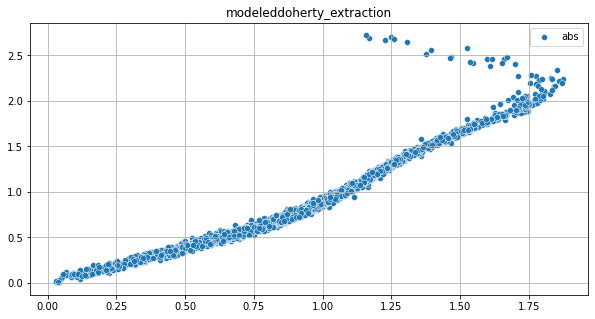

*** BEST ***
Shape:25 M:8 HL:20 nmse:-35.92296838760376 time:535.7540552616119
*** BEST ***
Shape:25 M:8 HL:21 nmse:-37.78100252151489 time:519.4988420009613
*** BEST ***
Shape:28 M:9 HL:20 nmse:-41.85326099395752 time:606.6283621788025
*** BEST ***
Shape:28 M:9 HL:21 nmse:-42.22189426422119 time:412.4887924194336
Validação - nmse:-26.971802711486816
Model: "model_wrapper_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 parte_real (Functional)     (None, 1)                 631       
                                                                 
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________
Model: "model_wrapper_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 parte_imag (Functional)     (None, 1)                 631       
   

In [49]:
# Problema inverso
p = Path().glob('../data/modeleddoherty_extraction.csv')

data = load_csv2numpy(p)
 
x = data[:, 2] + 1j*data[:, 3]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()
M = 9
HL = 21

nmse = validation(model, x, y, M)

# best_model, M = find_best_M_HL(x, y, M_min=8, M_max=10, HL_min=20, HL_max=22)

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 2] + 1j*data[:, 3]
x = normalize_data(x)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)

nmse = validation(model, x, y, M)

In [17]:
custom_objects = {"ModelWrapper": lm.ModelWrapper}
model_real = tf.keras.models.load_model('./model_dohertz_imag.h5', custom_objects=custom_objects)
model_imag = tf.keras.models.load_model('./model_dohertz_imag.h5', custom_objects=custom_objects)
model = [model_real, model_imag]

TypeError: ModelWrapper.__init__() got an unexpected keyword argument 'name'

In [ ]:
custom_objects = {"ModelWrapper": lm.ModelWrapper, "custom_activation": lm.MeanSquaredError}